In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['TSLA','FB','AMZN','GOOG','TWTR']**

In [2]:
import yfinance as yf
stock_symbol = 'GOOG'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
499,2022-03-22,2730.000000,2830.000000,2730.000000,2805.550049,2805.550049,1488800
500,2022-03-23,2782.770020,2800.500000,2763.330078,2770.070068,2770.070068,1265100
501,2022-03-24,2785.449951,2827.929932,2760.788086,2826.239990,2826.239990,1027200
502,2022-03-25,2835.080078,2839.189941,2793.989990,2830.429932,2830.429932,963500
503,2022-03-28,2813.689941,2839.530029,2796.562988,2839.000000,2839.000000,1186800


#### Visualizing the Real Stock Trend

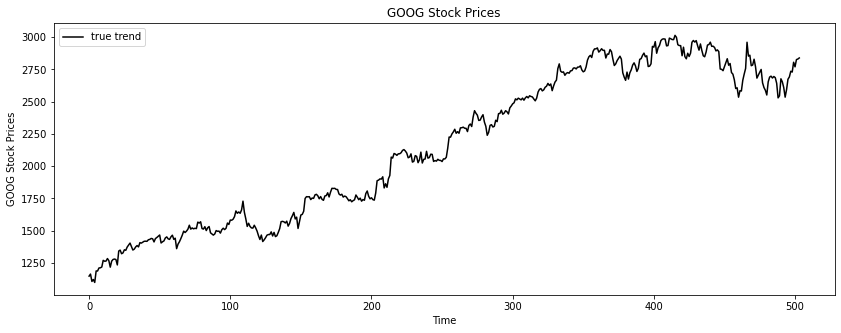

In [3]:
plt.figure(figsize=(14,5))
plt.plot(data['Close'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [4]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((504, 7), (444, 7), (60, 7))

#### Preparing the training data

In [5]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,1125.040039,1151.630005,1096.479980,1146.819946,2574100
1,1147.300049,1175.310059,1138.140015,1162.810059,2486400
2,1122.000000,1129.689941,1097.449951,1105.619995,2344200
3,1098.260010,1126.859985,1096.400024,1120.839966,1964900
4,1119.015015,1123.540039,1079.810059,1097.880005,2313400


In [6]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.0139353 , 0.0146802 , 0.00869158, 0.02553877, 0.5592999 ])

In [7]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,3])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape

((384, 60, 5), (384,))

#### Preparaing testing data

In [8]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((120, 5),
             Open         High          Low        Close   Volume
 384  2692.510010  2757.040039  2689.729980  2747.080078   988200
 385  2777.260010  2803.089111  2771.260010  2783.709961   912500
 386  2798.120117  2806.340088  2788.586914  2801.120117   946200
 387  2796.000000  2815.272949  2776.129883  2776.949951   829200
 388  2792.750000  2793.899902  2725.000000  2734.260010  1126800)

In [9]:
df = scaler.transform(df)
df[0]

array([0.82958673, 0.85368915, 0.83940059, 0.86061688, 0.1610627 ])

In [10]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,3])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((60, 60, 5), (60,))

#### Defining the Scaling Label

In [11]:
# below is the scaling label, which will help inverse the transformation back to it's original values 
data_close = data.Close
data_close = data_close.values.reshape(-1, 1)
scaler_close = MinMaxScaler()
data_close_scaled = scaler_close.fit_transform(data_close)

In [12]:
y_test = y_test.reshape(-1,1)
y_test = scaler_close.inverse_transform(y_test)

#### GRU - Gated Recurrent Unit

In [13]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [14]:
x_train.shape[1],x_train.shape[2]

(60, 5)

In [15]:
model = Sequential()

# Input layer
model.add(GRU(units=40,activation='relu',return_sequences=False, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40)                5640      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 5,681
Trainable params: 5,681
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [17]:
def forecast():
    model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return y_pred

In [18]:
def first_forecast():
    history = model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return history,y_pred

In [19]:
result_forecast = []
simulation = 3
print("Simulation 1")
history,first_result = first_forecast()
result_forecast.append(first_result)
for i in range(1,simulation):
    print("Simulation %d"%(i+1))
    result_forecast.append(forecast())


Simulation 1
Epoch 1/300
12/12 [==============================] - 1s 12ms/step - loss: 0.6290 - accuracy: 0.0000e+00
Epoch 2/300
12/12 [==============================] - 0s 12ms/step - loss: 0.2929 - accuracy: 0.0000e+00
Epoch 3/300
12/12 [==============================] - 0s 10ms/step - loss: 0.0930 - accuracy: 0.0000e+00
Epoch 4/300
12/12 [==============================] - 0s 11ms/step - loss: 0.0318 - accuracy: 0.0026
Epoch 5/300
12/12 [==============================] - 0s 11ms/step - loss: 0.0262 - accuracy: 0.0026
Epoch 6/300
12/12 [==============================] - 0s 11ms/step - loss: 0.0202 - accuracy: 0.0026
Epoch 7/300
12/12 [==============================] - 0s 11ms/step - loss: 0.0175 - accuracy: 0.0026
Epoch 8/300
12/12 [==============================] - 0s 11ms/step - loss: 0.0163 - accuracy: 0.0026
Epoch 9/300
12/12 [==============================] - 0s 11ms/step - loss: 0.0128 - accuracy: 0.0026
Epoch 10/300
12/12 [==============================] - 0s 11ms/step - loss: 

#### Calculating the Accuracy using MAPE and RMSE

In [20]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[97.90271699053848, 98.05198409002001, 98.18047478509527]

In [21]:
# RMSE - Root Mean Squared Error 
def calculate_rmse(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict)/real)))
    return percentage * 100
mean_rmse = []
for i in range(simulation):
    mean_rmse.append(calculate_rmse(y_test, result_forecast[i]))

mean_rmse,np.mean(mean_rmse)

([97.24761618233416, 97.49503561349286, 97.66634281522062], 97.46966487034922)

#### Visualization

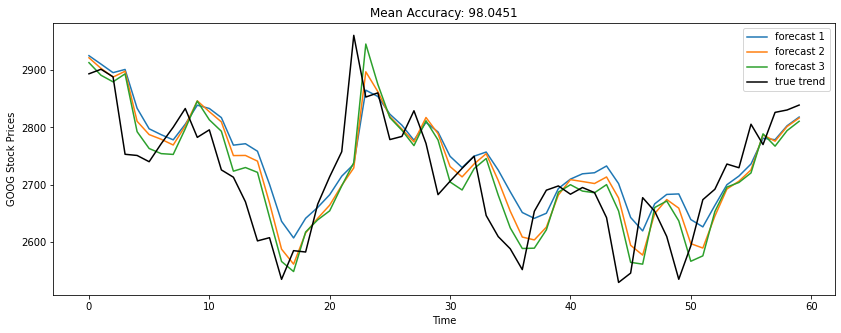

In [22]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

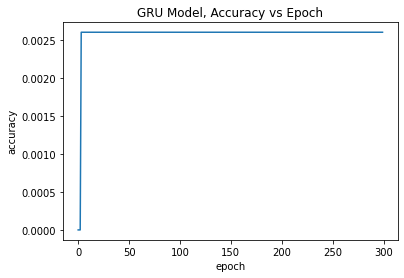

In [24]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('GRU Model, Accuracy vs Epoch')
plt.show()

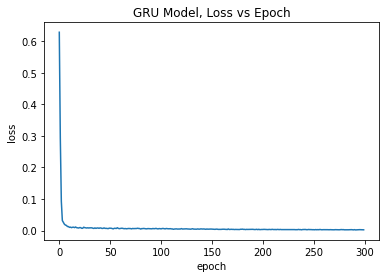

In [25]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('GRU Model, Loss vs Epoch')
plt.show()

In [26]:
present_test_set = data_test
present_test_set = present_test_set.drop(['Date','Adj Close'],axis=1)

#scale the data
present_input = scaler.transform(present_test_set)

# preparing the arrays according to the test_size
present_test = []
present_test.append(present_input)

for i in range(1,test_size):
    a = [0,0,0,0,0]
    ar = []
    for j in range(0,test_size):
        ar.append(a)
    present_test.append(ar)

present_test = np.array(present_test)

y = model.predict(present_test)
predicted_value = y.reshape(-1,1)
predicted_value = scaler_close.inverse_transform(predicted_value)
print("Next Day's Predicted Closing Index = %f"%predicted_value[0])

Next Day's Predicted Closing Index = 2806.769043


### Final Analysis

>**Dataset:**
>* GOOG
>* 2y  
>
>**Training Timestamp:**
>* 60 days
>  
>**Model:**
>* 2 layers - (1 Input + 1 Output)
>* GRU layer - activation = relu
>* GRU layer - units = 40
>* GRU layers - dropout = 0.2
>* Dense layer - units = 1  
>
>**Compile:**
>* optimizer = adam
>
>**Training:**
>* epochs: 300
>* batch_size = 32
>
>**Mean Accuracy:**
>* MAPE - 93.09%
>* RMSE - 91.39%

**Predicted Closing Index for 29th March: 2806.769043**